## 1. 라이브러리 임포트 및 환경 설정
- 필요한 라이브러리 임포트
- 시드 고정 및 GPU/CPU 설정

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
%matplotlib inline

from cv2 import resize
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 시드(seed) 고정
random_seed = 2024
tf.random.set_seed(random_seed)  # TensorFlow 전용 난수 시드 고정
np.random.seed(random_seed)      # NumPy 난수 시드 고정
random.seed(random_seed)         # Python random 시드 고정

# GPU가 사용 가능한지 확인
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
else:
    device = "CPU"

print(f"Using device: {device}")

Using device: GPU


## 2. Google Drive 연결 및 데이터 경로 설정
- Colab 환경에서 Google Drive를 마운트하여 데이터셋에 접근

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets

/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets


In [11]:
#Create Files_Name
image_data='/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets/train'
pd.DataFrame(os.listdir(image_data),columns=['Class'])

,Class
0,Electrical-damage
1,Physical-Damage
2,Snow-Covered
3,Bird-drop
4,Dusty
5,Clean


## 3. 데이터 준비 및 시각화
### 3.1 데이터 로드
- 학습 데이터와 검증 데이터를 8:2 비율로 분리

In [14]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets/train',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets/train',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=False)

Found 706 files belonging to 6 classes.
Using 565 files for training.
Found 706 files belonging to 6 classes.
Using 141 files for validation.


### 3.2 데이터 시각화
- 학습 데이터에서 샘플 이미지를 출력

In [15]:
class_names = train_ds.class_names
print(class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


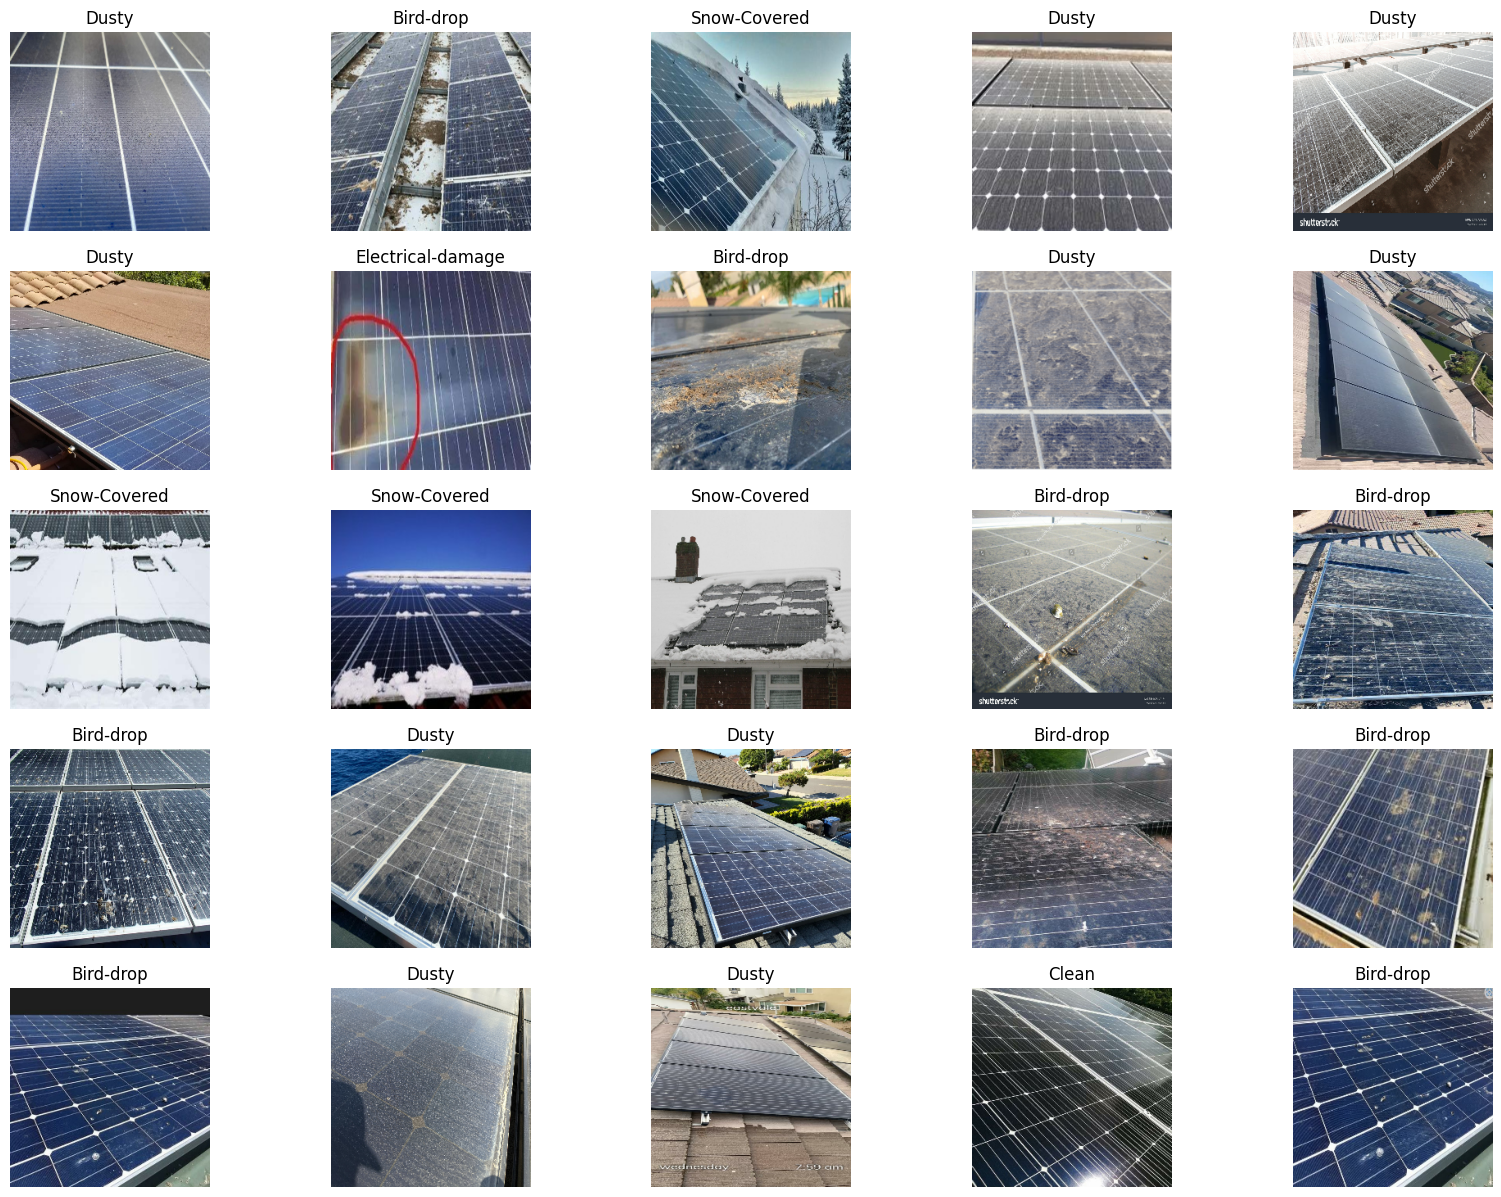

In [16]:
plt.figure(figsize=(20, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 4. VGG19 모델 정의 및 학습
### 4.1 모델 정의
- 사전 학습된 VGG19 모델을 불러오고, 커스텀 분류기를 추가

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 244, 244, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 244, 244, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 7, 7, 512)      │     20,024,384 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 90)             │         46,170 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,070,554 (76.56 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

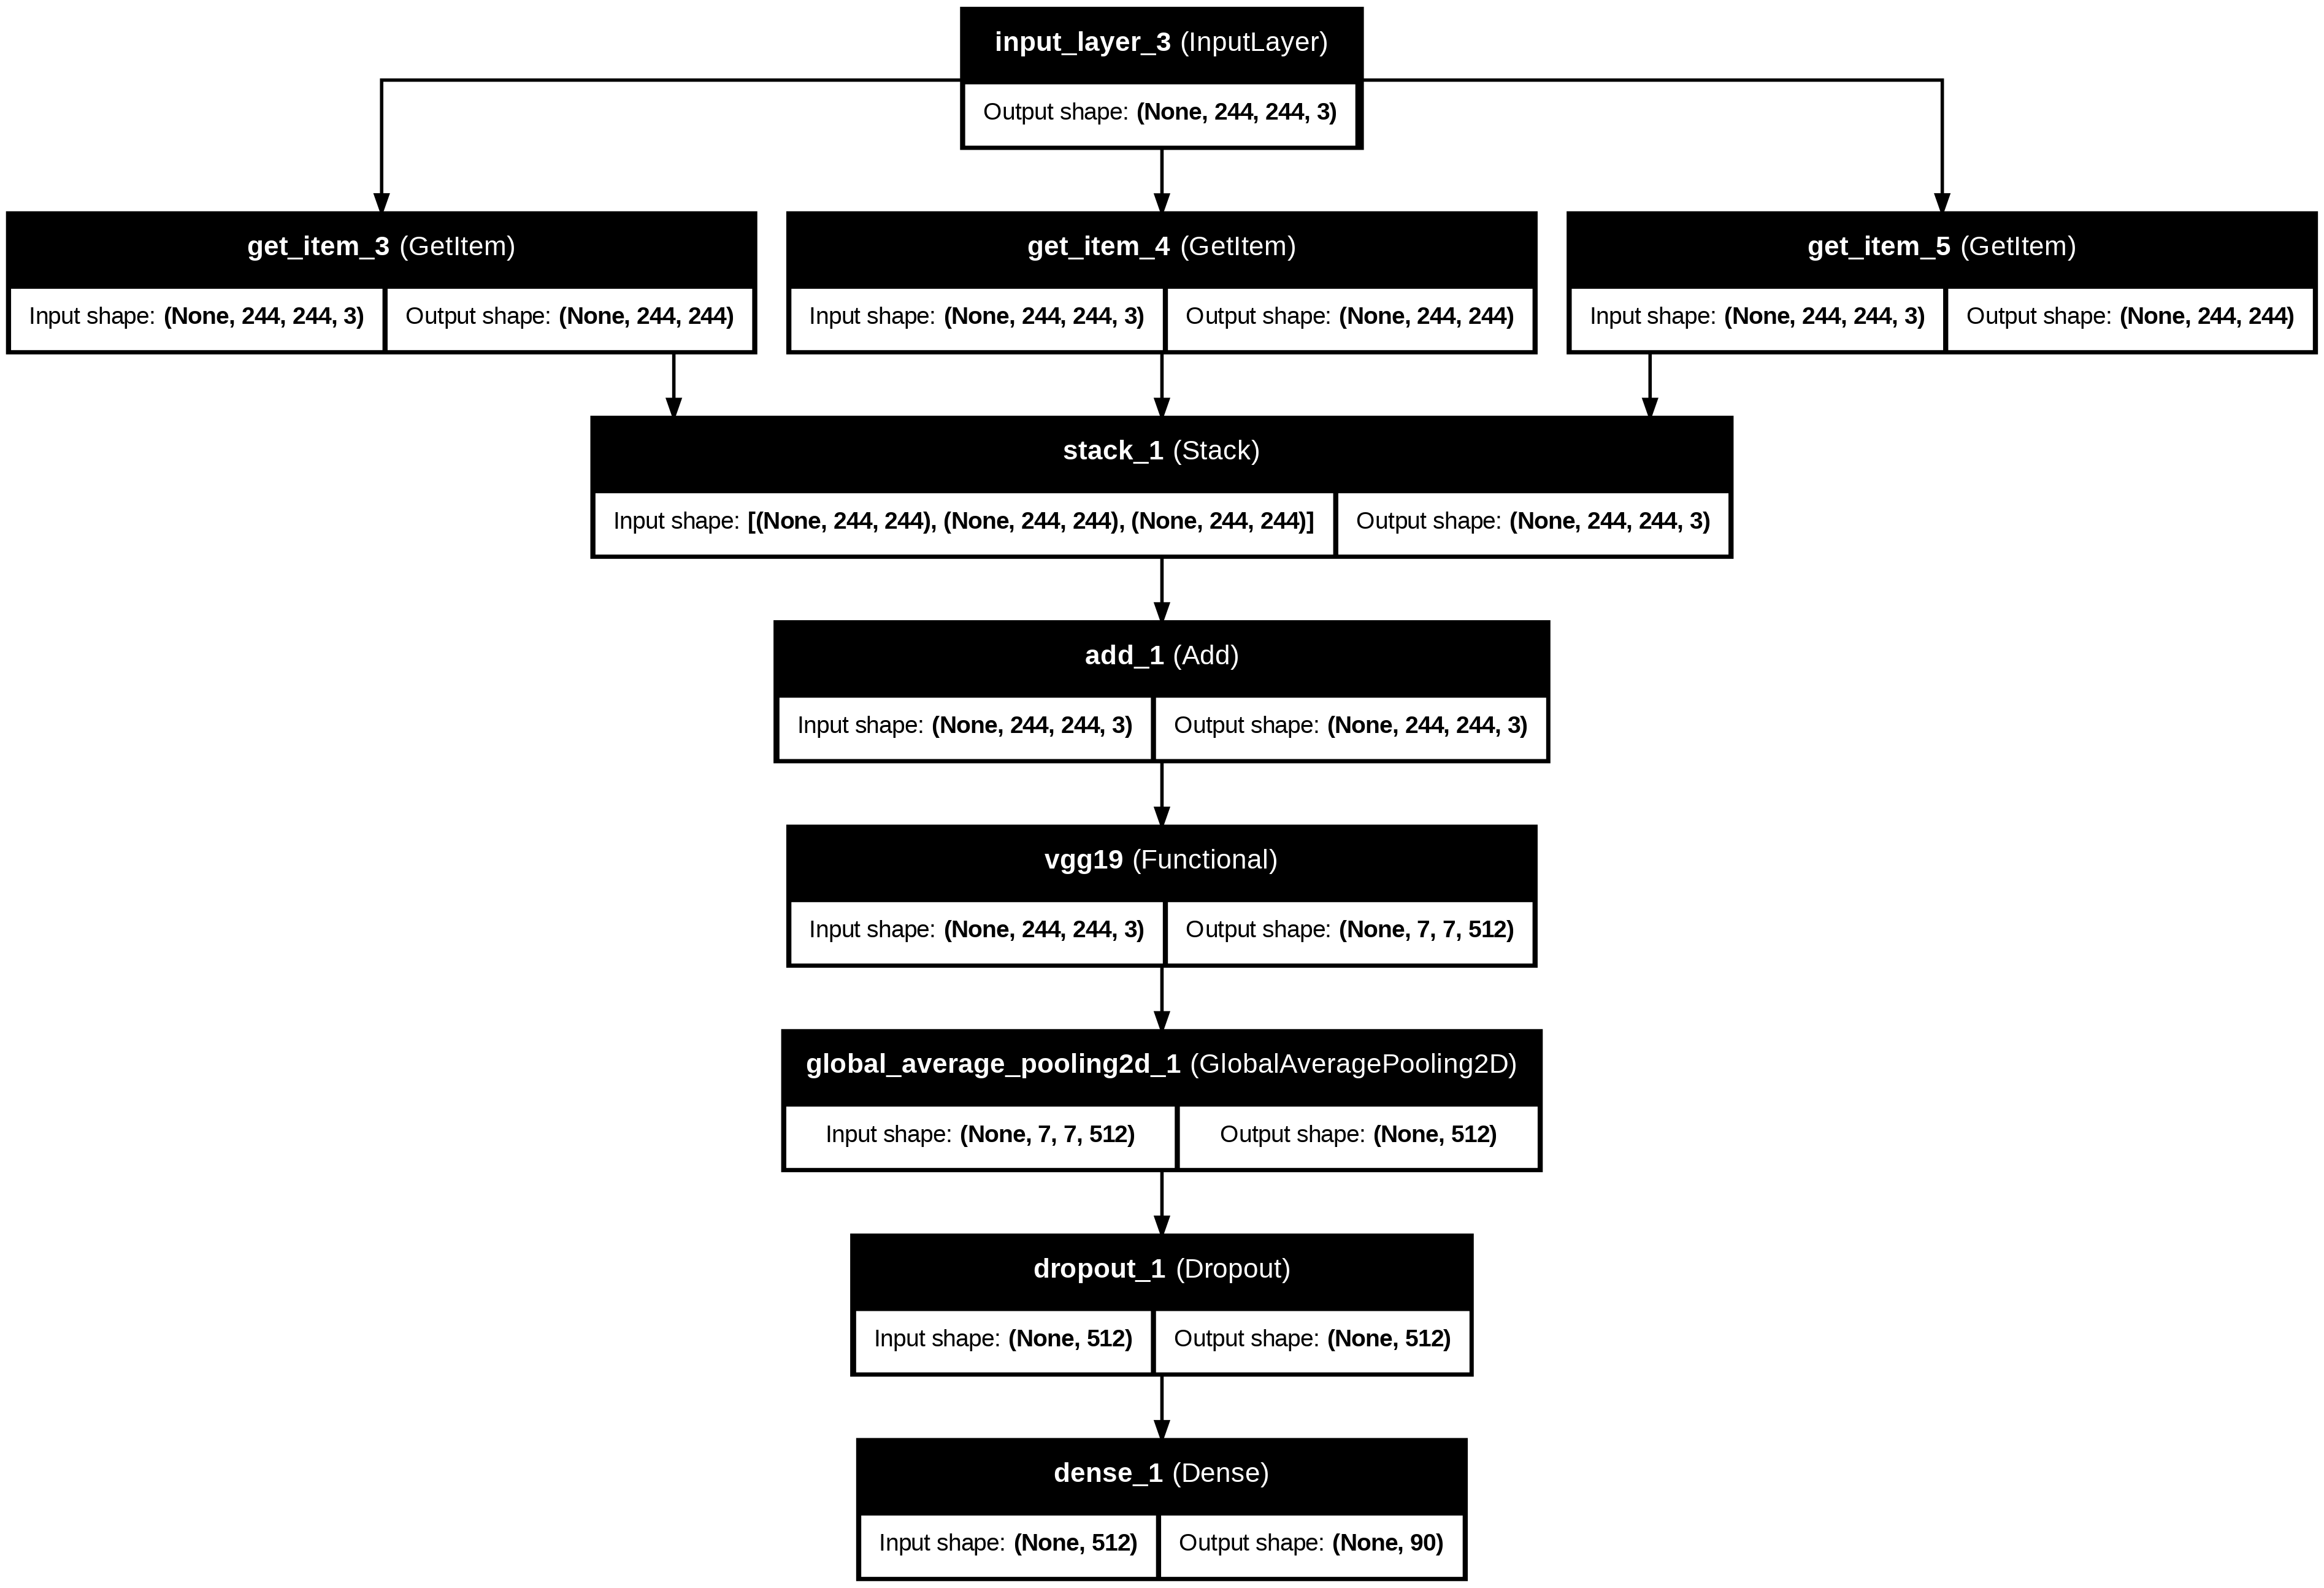

In [ ]:
import tensorflow as tf  # Assuming you're using TensorFlow

from tensorflow.keras.utils import plot_model

# Assuming you have your Keras model defined as 'model'

plot_model(model, to_file='vgg19_plot.png', show_shapes=True, show_layer_names=True)

### 4.2 모델 학습 및 Early Stopping
- Early Stopping을 적용하여 학습

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
%%timeit

epoch = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 192s 10s/step - accuracy: 0.0497 - loss: 13.3580 - val_accuracy: 0.2128 - val_loss: 5.4674
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 0.2414 - loss: 6.0396 - val_accuracy: 0.3759 - val_loss: 3.7264
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - accuracy: 0.3056 - loss: 4.7152 - val_accuracy: 0.5106 - val_loss: 2.2217
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.3883 - loss: 3.3940 - val_accuracy: 0.5674 - val_loss: 1.7544
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - accuracy: 0.4796 - loss: 2.7513 - val_accuracy: 0.6667 - val_loss: 1.3461
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 637ms/step - accuracy: 0.5007 - loss: 2.5697 - val_accuracy: 0.7092 - val_loss: 1.2706
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.5396 - loss: 2.0397 - val_accuracy: 0.7660 - val_loss: 0.9439
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.6042 - loss: 1.7417 - val_accura

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.669027,1.356127,0.680851,1.027249
1,0.830088,0.557655,0.730496,1.156033
2,0.877876,0.341190,0.801418,0.772864
3,0.927434,0.203875,0.780142,0.758350
4,0.950442,0.145267,0.794326,0.804133
5,0.962832,0.115448,0.815603,0.600200
6,0.982301,0.070779,0.815603,0.773717
7,0.982301,0.074388,0.829787,0.857726
8,0.985841,0.052216,0.787234,1.315779


## 5. 테스트 데이터 평가 및 성능 분석
### 5.1 테스트 데이터 로드
- 테스트 데이터를 로드하여 성능 평가

In [ ]:
# 테스트 데이터 로드
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/24-2 딥러닝 팀플/test',  # test 데이터 경로
    image_size=(img_height, img_width),
    batch_size=32,
    seed=42,
    shuffle=False  # 테스트 데이터는 셔플하지 않음
)

Found 179 files belonging to 6 classes.


### 5.2 Confusion Matrix 생성 및 정확도 계산
- 테스트 데이터에서 혼동 행렬과 정확도를 계산

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step
     Actual  Prediction
0         0           2
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
174       5           5
175       5           5
176       5           5
177       5           5
178       5           5

[179 rows x 2 columns]


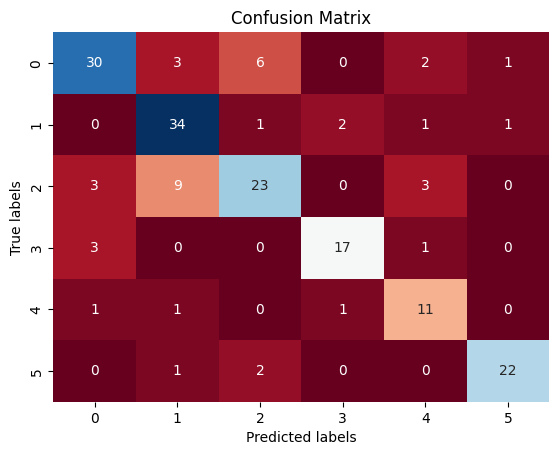

Test Data Accuracy: 76.54%


In [ ]:
# 테스트 데이터에서 예측 결과 생성
X_test, y_test, y_pred = [], [], []

# 테스트 데이터 수집
for images, labels in test_ds:
    y_test.extend(labels.numpy())  # 실제 라벨 저장
    X_test.extend(images.numpy())  # 이미지 저장

# 모델 예측
predictions = model.predict(np.array(X_test))
for i in predictions:
    y_pred.append(np.argmax(i))  # 각 샘플에 대해 가장 높은 확률의 클래스 선택

# 데이터프레임 생성
df = pd.DataFrame()
df['Actual'], df['Prediction'] = y_test, y_pred
print(df)

# Confusion Matrix 생성 및 시각화
from sklearn.metrics import confusion_matrix, accuracy_score

ax = plt.subplot()
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# 정확도 계산
Acc = accuracy_score(y_test, y_pred)
print("Test Data Accuracy: {0:.2f}%".format(Acc * 100))

### 5.3 테스트 데이터 예측 시각화
- 테스트 데이터 샘플을 출력하고 예측 결과와 실제 라벨을 비교

In [ ]:
# 테스트 데이터에서 각 클래스별 4개 샘플 출력
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 가져오기
class_names = test_ds.class_names

# 클래스별 샘플 저장용 딕셔너리 초기화
class_samples = {label: [] for label in range(len(class_names))}

# 각 클래스별 최대 4개 샘플 선택
for images, labels in test_ds:
    for i in range(len(labels)):
        label = labels[i].numpy()  # 현재 이미지의 클래스
        if len(class_samples[label]) < 4:  # 해당 클래스에서 최대 4개까지만 추가
            class_samples[label].append(images[i])
        if all(len(samples) == 4 for samples in class_samples.values()):  # 모든 클래스에서 4개씩 선택 완료
            break
    if all(len(samples) == 4 for samples in class_samples.values()):
        break

# 시각화: 각 클래스당 4개 샘플 출력
plt.figure(figsize=(20, 20))
plot_idx = 1
for label, images in class_samples.items():
    for img in images:
        ax = plt.subplot(len(class_names), 4, plot_idx)

        # 이미지 표시
        image = img.numpy().astype("uint8")
        plt.imshow(image)

        # 현재 이미지에 대한 예측 수행
        predictions = model.predict(tf.expand_dims(img, 0))
        score = tf.nn.softmax(predictions[0])

        # 예측 클래스와 실제 클래스
        predicted_class_idx = np.argmax(score)
        predicted_class_label = class_names[predicted_class_idx]
        actual_class_label = class_names[label]

        # 정확도 및 라벨 색상 설정
        if actual_class_label == predicted_class_label:
            color = 'green'
            accuracy_text = f"Correct ({actual_class_label})"
        else:
            color = 'red'
            accuracy_text = f"Incorrect (Actual: {actual_class_label}, Predicted: {predicted_class_label})"

        # 예측 확률 계산 및 출력
        score_np = score.numpy()  # TensorFlow Tensor → NumPy 배열 변환
        predicted_prob = round(score_np[predicted_class_idx] * 100, 2)  # 확률 백분율

        # 타이틀 추가
        plt.title(f"{accuracy_text}\nProb: {predicted_prob}%", color=color, fontsize=10)
        plt.axis("off")
        plot_idx += 1

plt.tight_layout()  # Subplot 간 간격 조정
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [2]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)  # epoch 수
train_accuracy = history.history['accuracy']  # 모델 학습 시 accuracy
val_accuracy = history.history['val_accuracy']  # 모델 검증 시 accuracy

# 그래프 그리기
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')  # Training Accuracy
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')  # Validation Accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'model' is not defined